In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score
import torch
import sys
import torchsummary

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.CropTypeClassifier import *


plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,
    "font.size": 16,
    "font.family": "Computer Modern Roman"
    })

figure_results_path = "C:/Users/Ivica Obadic/paper_plots/appendix"

NUM_CLASSES = 12
RESULTS_BASE_DIR = "C:/Users/results/{}_classes/original_sequences".format(NUM_CLASSES)

def read_classification_results(classification_results_dir):
    classification_results_path = os.path.join(classification_results_dir, "predictions", "classification_metrics.csv")
    if (os.path.exists(classification_results_path)):
        classification_data = np.genfromtxt(classification_results_path, delimiter=',', skip_header = 1)
        return classification_data
    return None


def get_classification_results_per_seq_aggr_method(seq_aggr_method_dir):
    result_list = []
    seg_aggr_method = os.path.basename(seq_aggr_method_dir)
    root_result_dirs = [seq_aggr_method_dir]
    if seg_aggr_method == "sampling":
        root_result_dirs = [os.path.join(seq_aggr_method_dir, sampling_result_dir) for sampling_result_dir in os.listdir(seq_aggr_method_dir)]
    
    for root_result_dir in root_result_dirs:
        pos_enc_dirs = [os.path.join(root_result_dir, pos_enc_method) for pos_enc_method in os.listdir(root_result_dir)]
        for pos_enc_opt_dir in pos_enc_dirs:
            pos_enc_opt = os.path.basename(pos_enc_opt_dir)
            for model_config in os.listdir(pos_enc_opt_dir):
                model_result_dir = os.path.join(pos_enc_opt_dir, model_config)
                classification_results = read_classification_results(model_result_dir)
                if classification_results is not None:
                    model_hyperparameters = model_config.split(",")
                    num_layers = model_hyperparameters[0].split("=")[1]
                    num_heads = model_hyperparameters[1].split("=")[1]
                    emb_dim = model_hyperparameters[2].split("=")[1]
                    result_list.append((
                        seg_aggr_method,
                        pos_enc_opt,
                        num_layers,
                        num_heads,
                        emb_dim,
                        classification_results[1],
                        classification_results[2],
                        classification_results[6]))
    
    result_df = pd.DataFrame(result_list, 
                        columns=["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM", "ACCURACY", "AVERAGE_CLASS_ACCURACY", "F1_SCORE"])
    result_df.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)    
    return result_df


def get_parcel_region_mapping(
    root_parcel_mapping_dir = "C:/Users/Ivica Obadic/Desktop/Explainable Machine Learning in Earth Observations/Projects/EO_explainability_survey/Datasets/BavarianCrops/ids/blocks"):
    parcel_region_mapping = []
    parcel_mapping_files = [("holl", os.path.join(root_parcel_mapping_dir, "holl_test.txt")),
                            ("nowa", os.path.join(root_parcel_mapping_dir, "nowa_test.txt")),
                            ("krum", os.path.join(root_parcel_mapping_dir, "krum_test.txt"))]
    
    for region, parcel_mapping_file in parcel_mapping_files:
            with open(parcel_mapping_file, 'r') as parcel_mapping:
                parcels_for_region = [(region, int(parcel_id.strip())) for parcel_id in parcel_mapping.readlines()]
                parcel_region_mapping.extend(parcels_for_region)
    
    parcel_region_mapping_df = pd.DataFrame(parcel_region_mapping, columns = ["REGION", "PARCEL_ID"])
    return parcel_region_mapping_df

def calc_accuracy_stats_region_wise(parcel_region_mapping, model_root_path, aggregation_method):
    
    def calc_accuracy_per_region(df_region):
        accuracy = accuracy_score(df_region["LABEL"], df_region["PREDICTION"])
        f1 = f1_score(df_region["LABEL"], df_region["PREDICTION"], average="macro", zero_division=0)
        kappa = cohen_kappa_score(df_region["LABEL"], df_region["PREDICTION"])
        return pd.Series({'F1 SCORE': f1, 'AGGREGATION_METHOD': aggregation_method})
        #return pd.Series({'ACCURACY': accuracy, 'F1_SCORE': f1, 'KAPPA_SCORE': kappa, 'MODEL': aggregation_method})
    
    predictions_file = os.path.join(model_root_path, aggregation_method, "predictions", "predicted_vs_true.csv")
    predictions = pd.read_csv(predictions_file)
    predictions_with_region = pd.merge(parcel_region_mapping, predictions, on="PARCEL_ID")
    predictions_with_region = predictions_with_region.groupby("REGION").apply(calc_accuracy_per_region).reset_index()
    return predictions_with_region


def seq_aggr_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results.replace({"right_padding": "Right padding", "sampling": "Random sampling", "weekly_average": "Weekly average"}, inplace=True)
    all_results.rename(columns={"SEQ_AGGR": "SEQUENCE AGGREGATION STRATEGY", "AVERAGE_CLASS_ACCURACY": "Class accuracy", "F1_SCORE": "F1 score"}, inplace=True)
    all_results = pd.melt(all_results, id_vars=['SEQUENCE AGGREGATION STRATEGY'], value_vars=['Class accuracy', 'F1 score'], var_name="Metric", value_name="Score")
    fig, axs = plt.subplots(figsize=(7, 6))
    boxplot = sns.boxplot(x="SEQUENCE AGGREGATION STRATEGY", y="Score",
            hue="Metric", palette=["m", "g"],
            data=all_results, ax = axs)
    boxplot.set(xlabel=None)
    fig.tight_layout()
    plt.savefig(os.path.join(figure_results_path, 'seq_aggr_comparison.eps'), dpi=400)
    
def seq_aggr_pos_enc_strategy_comparison_plot(results_padding, results_weekly_average, results_sampling):
    all_results = pd.concat([results_padding, results_weekly_average, results_sampling])
    all_results.sort_values(by=["AVERAGE_CLASS_ACCURACY"], inplace=True, ascending=False)
    all_results.replace({"right_padding": "Right padding", "sampling": "Random sampling", "weekly_average": "Weekly average", "obs_aq_date": "Observation acquisition date", "seq_order": "Sequence order"}, inplace=True)
    all_results.rename(columns={"SEQ_AGGR": "Aggregation approach", "F1_SCORE": "F1 score", "POS_ENC": "Positional encoding"}, inplace=True)
    all_results = pd.melt(all_results, id_vars=["Aggregation approach", "Positional encoding"], value_vars=["F1 score"], var_name="METRIC", value_name="F1 score")
    fig, axs = plt.subplots(figsize=(7, 6))
    boxplot = sns.boxplot(x="Aggregation approach", y="F1 score",
            hue="Positional encoding", order=["Right padding", "Weekly average", "Random sampling"],
            data=all_results, ax = axs)
    boxplot.set(xlabel=None)

    plt.savefig(os.path.join(figure_results_path, 'pos_enc_comparison.eps'), dpi=400)



def hyperparams_partial_dependence_plot(results_table):
    
    seq_aggr_strategy = results_table["SEQ_AGGR"].values[0]
    avg_result_num_layers = results_table.groupby(["NUM_LAYERS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_num_heads = results_table.groupby(["NUM_HEADS"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = results_table.groupby(["EMB_DIM"]).agg({"AVERAGE_CLASS_ACCURACY": 'mean', "F1_SCORE": "mean"})
    avg_result_emb_dim = avg_result_emb_dim.sort_index()
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)
    num_layers_dependence_plot = sns.lineplot(data=avg_result_num_layers, ax = axs[0])
    num_heads_dependence_plot = sns.lineplot(data=avg_result_num_heads, ax = axs[1])
    emb_dim_dependence_plot = sns.lineplot(data=avg_result_emb_dim, ax = axs[2])
    fig.suptitle("Partial Dependence results for the {} sequence aggregation strategy".format(seq_aggr_strategy))
    

def get_num_model_params(model_root_path, sequence_length, num_classes, pos_enc_opt, model_dim, num_layers, num_heads):
    model_root_path = os.path.join(model_root_path, "best_model.pth")
    init_model = init_model_with_hyper_params(
        sequence_length,
        num_classes,
        pos_enc_opt,
        model_dim,
        num_layers,
        num_heads,
        False)
    snapshot = torch.load(model_root_path, map_location="cpu")
    model_state = snapshot.pop('model_state', snapshot)
    init_model.load_state_dict(model_state)
    return sum(p.numel() for p in init_model.parameters() if p.requires_grad)
    
    

In [3]:
seq_aggr_method = "right_padding"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
right_padding_results = get_classification_results_per_seq_aggr_method(results_path)
#hyperparams_partial_dependence_plot(right_padding_results)
right_padding_results.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], ascending=False)

,SEQ_AGGR,POS_ENC,NUM_LAYERS,NUM_HEADS,EMB_DIM,ACCURACY,AVERAGE_CLASS_ACCURACY,F1_SCORE
0,right_padding,obs_aq_date,1,1,128,0.916705,0.646532,0.670932
24,right_padding,seq_order,1,1,128,0.915211,0.640626,0.665129
12,right_padding,obs_aq_date,3,1,128,0.916073,0.646682,0.664205
6,right_padding,obs_aq_date,2,1,128,0.917624,0.633537,0.661384
8,right_padding,obs_aq_date,2,2,128,0.917624,0.633537,0.661384
42,right_padding,seq_order,4,1,128,0.911650,0.660512,0.658944
40,right_padding,seq_order,3,4,128,0.912339,0.641435,0.656854
32,right_padding,seq_order,2,2,128,0.910099,0.629816,0.656361
14,right_padding,obs_aq_date,3,2,128,0.913718,0.640839,0.655447
46,right_padding,seq_order,4,4,128,0.912626,0.632512,0.653500


In [4]:
seq_aggr_method = "weekly_average"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
weekly_average_results = get_classification_results_per_seq_aggr_method(results_path)
weekly_average_results
#hyperparams_partial_dependence_plot(weekly_average_results)

,SEQ_AGGR,POS_ENC,NUM_LAYERS,NUM_HEADS,EMB_DIM,ACCURACY,AVERAGE_CLASS_ACCURACY,F1_SCORE
9,weekly_average,obs_aq_date,3,1,128,0.896082,0.581060,0.596824
2,weekly_average,obs_aq_date,1,2,128,0.898495,0.576243,0.586155
5,weekly_average,obs_aq_date,1,4,64,0.898208,0.562567,0.583283
15,weekly_average,obs_aq_date,4,1,128,0.894933,0.563190,0.580733
0,weekly_average,obs_aq_date,1,1,128,0.892119,0.555111,0.578147
8,weekly_average,obs_aq_date,2,2,64,0.893325,0.560567,0.573009
11,weekly_average,obs_aq_date,3,2,128,0.892808,0.553264,0.570528
6,weekly_average,obs_aq_date,2,1,128,0.894014,0.549928,0.569392
7,weekly_average,obs_aq_date,2,1,64,0.895163,0.545063,0.566963
18,weekly_average,obs_aq_date,4,2,64,0.893325,0.557267,0.561604


In [5]:
seq_aggr_method = "sampling"
results_path = os.path.join(RESULTS_BASE_DIR, seq_aggr_method)
random_sampling_results = get_classification_results_per_seq_aggr_method(results_path)
#hyperparams_partial_dependence_plot(random_sampling_results)
averaged_sampling_results = random_sampling_results.groupby(["SEQ_AGGR", "POS_ENC", "NUM_LAYERS", "NUM_HEADS", "EMB_DIM"]).agg(["mean", "var"]).reset_index()
averaged_sampling_results.sort_values(by=[("F1_SCORE", "mean"), ("AVERAGE_CLASS_ACCURACY", "mean")], inplace=True, ascending=False)
averaged_sampling_results

SEQ_AGGR      POS_ENC NUM_LAYERS NUM_HEADS EMB_DIM  ACCURACY            \
                                                            mean       var   
8   sampling  obs_aq_date          2         2      64  0.906124  0.000016   
3   sampling  obs_aq_date          1         4     128  0.907169  0.000017   
9   sampling  obs_aq_date          2         4     128  0.906514  0.000010   
5   sampling  obs_aq_date          2         1     128  0.906905  0.000006   
11  sampling  obs_aq_date          3         1     128  0.907351  0.000004   
15  sampling  obs_aq_date          3         4     128  0.905044  0.000004   
13  sampling  obs_aq_date          3         2     128  0.905205  0.000025   
2   sampling  obs_aq_date          1         2     128  0.907820  0.000032   
0   sampling  obs_aq_date          1         1     128  0.909036  0.000003   
4   sampling  obs_aq_date          1         4      64  0.905457  0.000017   
10  sampling  obs_aq_date          2         4      64  0.902815  0.000043   
28  sampling    seq_order          2         1     128  0.901683  0.000005   
17  sampling  obs_aq_date          4         1     128  0.904573  0.000038   
21  sampling  obs_aq_date          4         4     128  0.904687  0.000016   
36  sampling    seq_order          3         2     128  0.902355  0.000009   
12  sampling  obs_aq_date          3         1      64  0.901832  0.000024   
40  sampling    seq_order          4         1     128  0.902700  0.000006   
7   sampling  obs_aq_date          2         2     128  0.904848  0.000011   
19  sampling  obs_aq_date          4         2     128  0.902792  0.000013   
32  sampling    seq_order          2         4     128  0.899954  0.000034   
30  sampling    seq_order          2         2     128  0.901792  0.000025   
22  sampling  obs_aq_date          4         4      64  0.901091  0.000007   
16  sampling  obs_aq_date          3         4      64  0.900942  0.000029   
6   sampling  obs_aq_date          2         1      64  0.902574  0.000026   
25  sampling    seq_order          1         2     128  0.902746       NaN   
26  sampling    seq_order          1         4     128  0.903102  0.000015   
38  sampling    seq_order          3         4     128  0.899380  0.000008   
14  sampling  obs_aq_date          3         2      64  0.900011  0.000007   
42  sampling    seq_order          4         2     128  0.899759  0.000010   
29  sampling    seq_order          2         1      64  0.900643  0.000017   
23  sampling    seq_order          1         1     128  0.902298  0.000014   
44  sampling    seq_order          4         4     128  0.900643  0.000009   
20  sampling  obs_aq_date          4         2      64  0.900402  0.000024   
34  sampling    seq_order          3         1     128  0.901448  0.000022   
1   sampling  obs_aq_date          1         1      64  0.903297  0.000002   
37  sampling    seq_order          3         2      64  0.898501  0.000017   
31  sampling    seq_order          2         2      64  0.898438  0.000008   
27  sampling    seq_order          1         4      64  0.897300  0.000019   
35  sampling    seq_order          3         1      64  0.896864  0.000020   
39  sampling    seq_order          3         4      64  0.897461  0.000022   
41  sampling    seq_order          4         1      64  0.897645  0.000017   
33  sampling    seq_order          2         4      64  0.896978  0.000006   
18  sampling  obs_aq_date          4         1      64  0.898840  0.000015   
43  sampling    seq_order          4         2      64  0.896737  0.000008   
24  sampling    seq_order          1         1      64  0.896243  0.000030   
45  sampling    seq_order          4         4      64  0.893569  0.000078   

   AVERAGE_CLASS_ACCURACY            F1_SCORE            
                     mean       var      mean       var  
8                0.628122  0.000276  0.640190  0.000274  
3                0.618160  0.000206  0.640032  0.000221  
9                0.617877  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


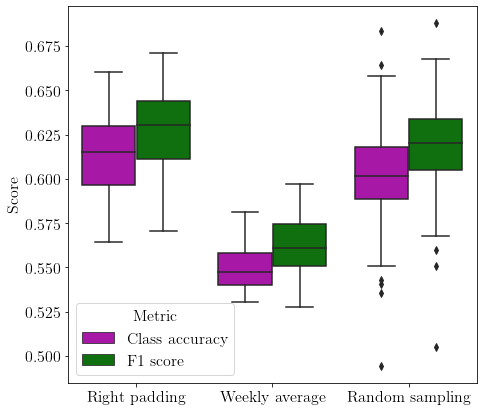

In [17]:
seq_aggr_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)

C:\Users\IVICAO~1\AppData\Local\Temp/ipykernel_23304/3974746497.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  seq_aggr_pos_enc_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


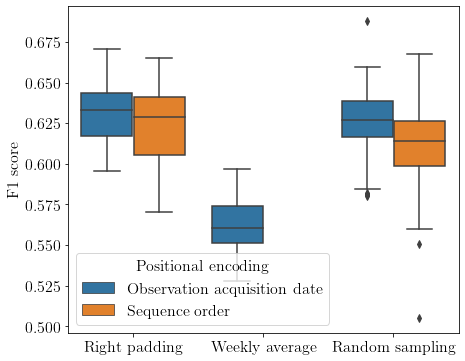

In [18]:
seq_aggr_pos_enc_strategy_comparison_plot(right_padding_results, weekly_average_results, random_sampling_results)

C:\Users\IVICAO~1\AppData\Local\Temp/ipykernel_1312/489177657.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


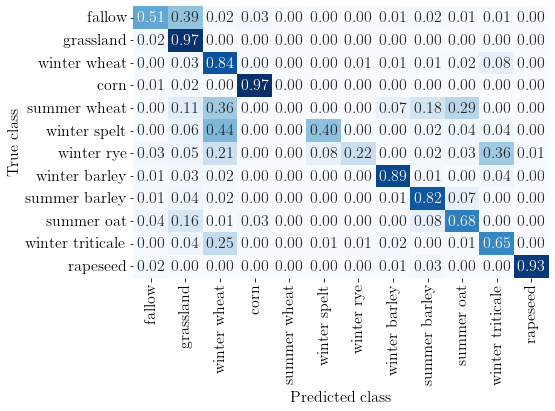

In [5]:
#confusion matrix analysis
best_model_cm_path = os.path.join(RESULTS_BASE_DIR, "right_padding", "0.1_frac_of_dates", "obs_aq_date", "layers=1,heads=1,emb_dim=128", "predictions", "confusion_matrix.csv")
cm = pd.read_csv(best_model_cm_path)
cm["True class"] = list(cm.columns)
cm.set_index("True class", inplace=True)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(ncols=1, figsize=(8, 6))

cm_plot = sns.heatmap(cmn, annot=True, cmap="Blues", cbar=None, fmt='.2f')
cm_plot.set_xlabel("Predicted class")
fig.tight_layout()
#plt.savefig(os.path.join(figure_results_path, 'conf_matr_occluded_winter_crops.eps'), dpi=400)

                      0
True class             
fallow              581
grassland         10878
winter wheat        995
corn               1917
summer wheat         56
winter spelt         52
winter rye          104
winter barley       777
summer barley      1017
summer oat          275
winter triticale    499
rapeseed            257


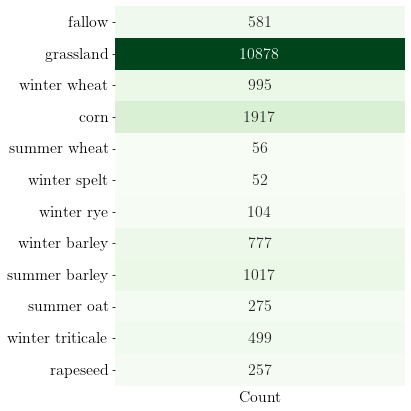

In [61]:
fig, axs = plt.subplots(ncols=1, figsize=(6, 6))
class_frequency = pd.DataFrame(cm.sum(axis=1))
print(class_frequency)
class_frequency_plot = sns.heatmap(class_frequency, annot=True, cbar=None, cmap="Greens", fmt="d", xticklabels=False)
#class_frequency_plot.set_title("Class Frequency")
class_frequency_plot.set_xlabel("Count")
class_frequency_plot.set_ylabel("")
fig.tight_layout()
plt.savefig(os.path.join(figure_results_path, 'class_frequency.eps'), dpi=400)

In [2]:
# #compare the best number of parameters from the right sampling model
# best_random_sampling_model = random_sampling_results.sort_values(by=["F1_SCORE", "AVERAGE_CLASS_ACCURACY"], ascending=False).iloc[0]
# print(best_random_sampling_model)
# best_random_sampling_model_layers = int(best_random_sampling_model[["NUM_LAYERS"]].values[0])
# best_random_sampling_model_heads = int(best_random_sampling_model[["NUM_HEADS"]].values[0])
# best_random_sampling_model_emb_dim = int(best_random_sampling_model[["EMB_DIM"]].values[0])
# best_random_sampling_model_pos_enc = best_random_sampling_model[["POS_ENC"]].values[0]
# random_sampling_best_model_path = os.path.join(RESULTS_BASE_DIR, "sampling", "random_70_obs_1632656397", best_random_sampling_model_pos_enc, "layers={},heads={},emb_dim={}".format(
#     best_random_sampling_model_layers,
#     best_random_sampling_model_heads,
#     best_random_sampling_model_emb_dim))
# print(get_num_model_params(
#     random_sampling_best_model_path,
#     70,
#     12,
#     best_random_sampling_model_pos_enc,
#     best_random_sampling_model_emb_dim,
#     best_random_sampling_model_layers,
#     best_random_sampling_model_heads))

NameError: name 'random_sampling_results' is not defined